In [50]:
import numpy as np
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt
import csv
import os
import cv2
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
import multiprocessing
from functools import partial

# Inter Observer Variablility

In [51]:
InterVar = pd.read_csv('CSV_Preds/InterVar.csv')
InterVar['index'] = range(1, len(InterVar) + 1)
InterVar.head()

,name,Observer – 1,Observer – 2,index
0,tile_24555_140484.png,32,21,1
1,tile_24555_142520.png,41,29,2
2,tile_24555_144556.png,45,26,3
3,tile_26192_80422.png,19,18,4
4,tile_26192_81440.png,35,26,5


In [57]:
fig = px.bar(InterVar, x='index', y=['Observer – 1', 'Observer – 2'], 
             barmode='overlay', opacity=0.7, 
             title='Inter Observer Variability')
fig.update_layout(xaxis_title='Sample Index', yaxis_title='Neutrophil Count')
fig.show()

In [52]:

fig = px.bar(InterVar, x='index', y=['Observer – 1', 'Observer – 2'], barmode='group', title='Inter Observer Variability')
fig.update_layout(xaxis_title='30 - Test samples', yaxis_title='Neutrophil count by each observer', xaxis_tickangle=-45, barcornerradius=15),
fig.show()

In [53]:
fig = px.line(InterVar, x='index', y=['Observer – 1', 'Observer – 2'], 
              title='Inter Observer Variability: Line Plot')
fig.update_layout(xaxis_title='Sample Index', yaxis_title='Neutrophil Count')
fig.show()

In [54]:
fig = px.box(InterVar, y=['Observer – 1', 'Observer – 2'], 
             title='Inter Observer Variability: Box Plot')
fig.update_layout(yaxis_title='Neutrophil Count')
fig.show()

In [67]:
fig = px.violin(InterVar, y=['Observer – 1', 'Observer – 2'], 
                title='Inter Observer Variability: Violin Plot')
fig.update_layout(yaxis_title='Neutrophil Count')
fig.show()

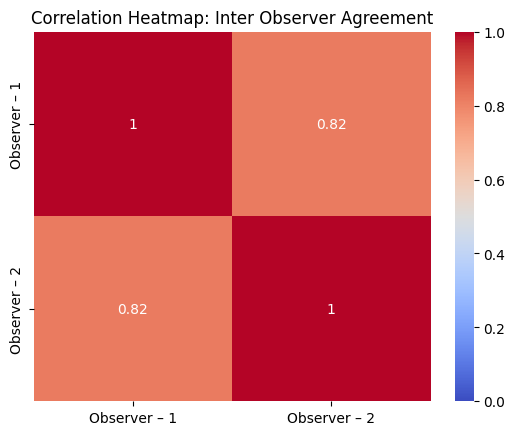

In [63]:
import seaborn as sns


corr = InterVar[['Observer – 1', 'Observer – 2']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlation Heatmap: Inter Observer Agreement')
plt.show()

In [2]:
def calculate_iou(box1, box2):
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    x1 = max(x1_1, x1_2)
    y1 = max(y1_1, y1_2)
    x2 = min(x2_1, x2_2)
    y2 = min(y2_1, y2_2)
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

In [3]:
def get_label(count):
    if count == 0:
        return 0
    elif count < 5:
        return 1
    else:
        return 2

In [64]:
def process_image(image_path, label_path, result, model_output_dir):
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape

    ground_truth_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                x1 = (x_center - width / 2) * image_width
                y1 = (y_center - height / 2) * image_height
                x2 = (x_center + width / 2) * image_width
                y2 = (y_center + height / 2) * image_height
                ground_truth_boxes.append([x1, y1, x2, y2])

    predicted_boxes = []
    for box in result.boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        predicted_boxes.append([x1, y1, x2, y2])

    missed = 0
    false_positives = 0
    true_positives = 0
    matched_gt_boxes = [False] * len(ground_truth_boxes)

    for pred_box in predicted_boxes:
        found = False
        best_iou = 0.1
        best_match_idx = -1

        for i, gt_box in enumerate(ground_truth_boxes):
            if not matched_gt_boxes[i]:
                iou = calculate_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_match_idx = i

        if best_match_idx != -1:
            true_positives += 1
            matched_gt_boxes[best_match_idx] = True
        else:
            false_positives += 1

    for i, matched in enumerate(matched_gt_boxes):
        if not matched:
            missed += 1

    for gt_box in ground_truth_boxes:
        cv2.rectangle(image, (int(gt_box[0]), int(gt_box[1])), (int(gt_box[2]), int(gt_box[3])), (0, 255, 0), 4)

    for pred_box in predicted_boxes:
        center_x = int((pred_box[0] + pred_box[2]) / 2)
        center_y = int((pred_box[1] + pred_box[3]) / 2)
        radius = int(min(pred_box[2] - pred_box[0], pred_box[3] - pred_box[1]) / 2)
        cv2.circle(image, (center_x, center_y), radius, (0, 0, 255), 4)

    text = f"Ground Truth: {len(ground_truth_boxes)}, Predicted: {len(predicted_boxes)}"
    cv2.putText(image, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)

    output_image_path = os.path.join(model_output_dir, f"output_{os.path.basename(image_path)}")
    plt.imsave(output_image_path, image)

    return missed, false_positives, true_positives, len(ground_truth_boxes), len(predicted_boxes)

def evaluate_models_for_label_dir(model_names, test_images_dir, test_labels_dir):
    model_performance = {}

    for model_name in model_names:
        model_output_dir = f"out/{model_name.replace('.pt', '')}_{os.path.basename(test_labels_dir.rstrip('/'))}"
        model_csv_path = f"output_metrics_{os.path.basename(test_labels_dir.rstrip('/'))}_{model_name.replace('.pt', '')}.csv"

        if os.path.exists(model_output_dir) and os.path.exists(model_csv_path):
            print(f"Loading results for model: {model_name} and label dir: {test_labels_dir} from existing CSV file")
            total_missed = 0
            total_false_positives = 0
            total_true_positives = 0

            with open(model_csv_path, mode="r") as csv_file:
                reader = csv.DictReader(csv_file)
                for row in reader:
                    total_missed += int(row["missed"])
                    total_false_positives += int(row["false_positives"])
                    total_true_positives += int(row["true_positives"])

            model_performance[model_name] = {
                "total_missed": total_missed,
                "total_false_positives": total_false_positives,
                "total_true_positives": total_true_positives
            }
            continue

        os.makedirs(model_output_dir, exist_ok=True)
        print(f"Evaluating model: {model_name} for label dir: {test_labels_dir}")
        model = YOLO(f"models/{model_name}")
        results = model.predict(source=test_images_dir, show_labels=False, show_conf=False, conf=0.075, verbose=False)

        total_missed = 0
        total_false_positives = 0
        total_true_positives = 0

        with open(model_csv_path, mode="w", newline="") as csv_file:
            fieldnames = [
                "name", "ground truth neutrophils", "predicted neutrophils", "missed",
                "false_positives", "true_positives", "label_groundtruth", "label_prediction"
            ]
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()

            for result in results:
                image_name = os.path.basename(result.path)
                image_path = os.path.join(test_images_dir, image_name)
                label_path = os.path.join(test_labels_dir, image_name.replace(".png", ".txt"))

                if not os.path.exists(label_path):
                    continue

                missed, false_positives, true_positives, gt_count, pred_count = process_image(
                    image_path, label_path, result, model_output_dir
                )

                total_missed += missed
                total_false_positives += false_positives
                total_true_positives += true_positives

                label_groundtruth = get_label(gt_count)
                label_prediction = get_label(pred_count)

                writer.writerow({
                    "name": image_name,
                    "ground truth neutrophils": gt_count,
                    "predicted neutrophils": pred_count,
                    "missed": missed,
                    "false_positives": false_positives,
                    "true_positives": true_positives,
                    "label_groundtruth": label_groundtruth,
                    "label_prediction": label_prediction
                })

        model_performance[model_name] = {
            "total_missed": total_missed,
            "total_false_positives": total_false_positives,
            "total_true_positives": total_true_positives
        }

    return model_performance

In [65]:
test_images_dir = "images/"
test_labels_dirs = ["Union_Labels/", "Intersection_Labels/", "labels_O1/", "labels_O2/"]
model_names = os.listdir("models")

for test_labels_dir in test_labels_dirs:
    print(f"Evaluating models for label directory: {test_labels_dir}")
    model_performance = evaluate_models_for_label_dir(model_names, test_images_dir, test_labels_dir)


    print(f"Performance for label directory {test_labels_dir}:")
    for model_name, metrics in model_performance.items():
        print(f"Model: {model_name}, Missed: {metrics['total_missed']}, False Positives: {metrics['total_false_positives']}, True Positives: {metrics['total_true_positives']}")

Evaluating models for label directory: Union_Labels/
Evaluating model: best_11x_datanew_NoAug_b16.pt for label dir: Union_Labels/
Evaluating model: best_11s_dataold_Noaug_b16.pt for label dir: Union_Labels/
Evaluating model: best_8s_dataold_Noaug_b16.pt for label dir: Union_Labels/
Evaluating model: best_11s_datanew_NoAug_b16.pt for label dir: Union_Labels/
Evaluating model: best_11s_1.pt for label dir: Union_Labels/
Evaluating model: best_11m_dataold_NoAug_b16.pt for label dir: Union_Labels/
Performance for label directory Union_Labels/:
Model: best_11x_datanew_NoAug_b16.pt, Missed: 276, False Positives: 295, True Positives: 605
Model: best_11s_dataold_Noaug_b16.pt, Missed: 131, False Positives: 929, True Positives: 750
Model: best_8s_dataold_Noaug_b16.pt, Missed: 221, False Positives: 538, True Positives: 660
Model: best_11s_datanew_NoAug_b16.pt, Missed: 249, False Positives: 406, True Positives: 632
Model: best_11s_1.pt, Missed: 174, False Positives: 657, True Positives: 707
Model: 

In [ ]:
def process_image(image_path, label_path, result, conf_threshold):
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape

    ground_truth_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                x1 = (x_center - width / 2) * image_width
                y1 = (y_center - height / 2) * image_height
                x2 = (x_center + width / 2) * image_width
                y2 = (y_center + height / 2) * image_height
                ground_truth_boxes.append([x1, y1, x2, y2])

    predicted_boxes = []
    for box in result.boxes:
        if box.conf[0] >= conf_threshold:
            x1, y1, x2, y2 = box.xyxy[0]
            predicted_boxes.append([x1, y1, x2, y2])

    matched_gt_boxes = [False] * len(ground_truth_boxes)
    true_positives = 0
    false_positives = 0

    for pred_box in predicted_boxes:
        found = False
        for i, gt_box in enumerate(ground_truth_boxes):
            if calculate_iou(pred_box, gt_box) > 0.1: 
                found = True
                if not matched_gt_boxes[i]:
                    true_positives += 1
                    matched_gt_boxes[i] = True
                break
        if not found:
            false_positives += 1

    return true_positives, false_positives, len(ground_truth_boxes)

def evaluate_threshold(conf_threshold, model, test_images_dir, test_labels_dir):
    results = model.predict(source=test_images_dir, show_labels=False, show_conf=False, conf=conf_threshold, verbose=False)

    total_true_positives = 0
    total_false_positives = 0
    total_ground_truth = 0

    for result in results:
        image_name = os.path.basename(result.path)
        image_path = os.path.join(test_images_dir, image_name)
        label_path = os.path.join(test_labels_dir, image_name.replace(".png", ".txt"))

        if not os.path.exists(label_path):
            continue

        true_positives, false_positives, ground_truth = process_image(image_path, label_path, result, conf_threshold)
        total_true_positives += true_positives
        total_false_positives += false_positives
        total_ground_truth += ground_truth

    precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    recall = total_true_positives / total_ground_truth if total_ground_truth > 0 else 0
    accuracy = total_true_positives / total_ground_truth if total_ground_truth > 0 else 0

    return conf_threshold, precision, recall, accuracy

def evaluate_all_models(model_names, test_images_dir, test_labels_dirs):
    confidence_thresholds = np.linspace(0.0, 1.0, 100)

    for model_name in model_names:
        print(f"Evaluating model: {model_name}")
        model = YOLO(f"models/{model_name}")

        for test_labels_dir in test_labels_dirs:
            print(f"Processing label directory: {test_labels_dir}")

            # Replace tqdm and list comprehension with a normal for loop
            results = []
            
            for conf_threshold in tqdm(confidence_thresholds, desc="Processing thresholds"):
                
                result = evaluate_threshold(conf_threshold, model, test_images_dir, test_labels_dir)
                results.append(result)

            conf_thresholds_tracked, precisions, recalls, accuracies = zip(*results)

            f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]

            fig = go.Figure()
            fig.add_trace(go.Scatter(
                x=recalls,
                y=precisions,
                mode='lines+markers',
                name='PR Curve',
                line=dict(color='rgba(0, 120, 220, 0.8)', width=3, dash='solid'),
                marker=dict(size=8, color='rgba(255, 80, 80, 0.9)', symbol='circle', line=dict(width=1, color='darkred')),
                hovertemplate=(
                    'Recall: %{x:.2f}<br>'
                    'Precision: %{y:.2f}<br>'
                    'Confidence: %{text:.2f}<br>'
                    'F1 Score: %{customdata[0]:.2f}<br>'
                    'Accuracy: %{customdata[1]:.2f}<extra></extra>'
                ),
                text=conf_thresholds_tracked,
                customdata=list(zip(f1_scores, accuracies))
            ))

            fig.add_trace(go.Scatter(
                x=recalls,
                y=precisions,
                fill='tozeroy',
                mode='none',
                name='Area Under Curve',
                fillcolor='rgba(0, 120, 220, 0.2)'
            ))

            specified_points = [
                {'precision': 0.84, 'recall': 0.58},
                {'precision': 0.58, 'recall': 0.84}
            ]

            for point in specified_points:
                fig.add_trace(go.Scatter(
                    x=[point['recall']],
                    y=[point['precision']],
                    mode='markers+text',
                    name=f"Precision={point['precision']}, Recall={point['recall']}",
                    marker=dict(size=10, color='green', symbol='star'),
                    text=[f"P={point['precision']}, R={point['recall']}"],
                    textposition='top center'
                ))

            fig.update_layout(
                title=f"Precision-Recall Curve for {model_name})",
                xaxis_title="Recall",
                yaxis_title="Precision",
                showlegend=True
            )
            fig.show()

In [ ]:
test_images_dir = "images/"
test_labels_dirs = ["Union_Labels/",  "labels_O1/", "labels_O2/""Intersection_Labels/", "labels_O1/", "labels_O2/"]
model_names = ["best_11s_1024_dataO2_NoAug_b16.pt"]

evaluate_all_models(model_names, test_images_dir, test_labels_dirs)

Evaluating model: best_11s_1024_dataO2_NoAug_b16.pt
Processing label directory: Union_Labels/


Processing thresholds: 100%|██████████| 100/100 [26:07<00:00, 15.68s/it]


Processing label directory: Intersection_Labels/


Processing thresholds: 100%|██████████| 100/100 [18:49<00:00, 11.29s/it]


Processing label directory: labels_O1/


Processing thresholds: 100%|██████████| 100/100 [20:40<00:00, 12.41s/it]


Processing label directory: labels_O2/


Processing thresholds: 100%|██████████| 100/100 [18:51<00:00, 11.31s/it]
